In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from fit import *
from NEF_RL import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Simulate RL_n with different $\sigma$

In [2]:
def run_RLn(sid, sigma):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    params = [mu, sigma]
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    for trial in human['trial'].unique():
        for stage in human['stage'].unique():
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = get_expectations_carrabin("RL_n", params, sid, trial, stage)
            dfs.append(pd.DataFrame([["RL_n", sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['sigma'] = sigma
    return dynamics_data

In [3]:
sid = 18
sigmas = [0.025, 0.05, 0.10]
dfs = []
for sigma in sigmas:
    dfs.append(run_RLn(sid, sigma))
RLn_data = pd.concat(dfs, ignore_index=True)

# Simulate NEF_RL with different $neurons$

In [3]:
def run_NEFRL(sid, n_neurons, n_error):
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    trials = human['trial'].unique() 
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    dfs = []
    for trial in trials:
        print(f"n_neurons {n_neurons}, n_error {n_error}, sid {sid}, trial {trial}")
        env = Environment(dataset="carrabin", sid=sid, trial=trial, decay="stages", s=[mu,mu,mu,mu,mu])
        seed_net = sid + 1000*trial
        net = build_network_RL(env, n_neurons=n_neurons, n_error=n_error, seed_net=seed_net, z=0, a=5e-5)
        sim = nengo.Simulator(net, seed=trial, progress_bar=False)
        with sim:
            sim.run(env.Tall, progress_bar=False)
        for stage in env.stages:
            tidx = int((stage*env.T)/env.dt)-2
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = sim.data[net.probe_value][tidx][0]
            df = pd.DataFrame([['NEF_RL', sid, trial, stage, qid, response]], columns=columns)
            dfs.append(df)
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['n_neurons'] = n_neurons
    dynamics_data['n_error'] = n_error
    return dynamics_data

In [5]:
sid = 18
n_values = [50, 200, 400]
n_errors = [50, 200, 400]
dfs = []
for v in n_values:
    for e in n_errors:
        dfs.append(run_NEFRL(sid, v, e))
NEFRL_data = pd.concat(dfs, ignore_index=True)

n_value 50, n_error 50, sid 18, trial 1
n_value 50, n_error 50, sid 18, trial 2
n_value 50, n_error 50, sid 18, trial 3
n_value 50, n_error 50, sid 18, trial 4
n_value 50, n_error 50, sid 18, trial 5
n_value 50, n_error 50, sid 18, trial 6
n_value 50, n_error 50, sid 18, trial 7
n_value 50, n_error 50, sid 18, trial 8
n_value 50, n_error 50, sid 18, trial 9
n_value 50, n_error 50, sid 18, trial 10
n_value 50, n_error 50, sid 18, trial 11
n_value 50, n_error 50, sid 18, trial 12
n_value 50, n_error 50, sid 18, trial 13
n_value 50, n_error 50, sid 18, trial 14
n_value 50, n_error 50, sid 18, trial 15
n_value 50, n_error 50, sid 18, trial 16
n_value 50, n_error 50, sid 18, trial 17
n_value 50, n_error 50, sid 18, trial 18
n_value 50, n_error 50, sid 18, trial 19
n_value 50, n_error 50, sid 18, trial 20
n_value 50, n_error 50, sid 18, trial 21
n_value 50, n_error 50, sid 18, trial 22
n_value 50, n_error 50, sid 18, trial 23
n_value 50, n_error 50, sid 18, trial 24
n_value 50, n_error 50, s

# Plot Behavioral Learning Rate and Excursions

In [6]:
sid = 18
human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
human['sigma'] = 'human'
human['n_value'] = 'human'
human['n_error'] = 'human'
RLn_data['n_value'] = 'RLn'
RLn_data['n_error'] = 'RLn'
NEFRL_data['sigma'] = 'NEF_RL'
combined = pd.concat([human, RLn_data, NEFRL_data], ignore_index=True)
combined['alpha'] = None
combined['excursion'] = None
for i, row in combined.iterrows():
    mt = row['type']
    trial = row['trial']
    stage = row['stage']
    qid = row['qid']
    n_value = row['n_value']
    n_error = row['n_error']
    response = row['response']
    avg_response = combined.query("type==@mt & n_value==@n_value & n_error==@n_error & qid==@qid")['response'].mean()
    combined.at[i, 'excursion'] = response - avg_response
    if stage>1:
        stage_old = stage - 1
        response_old = combined.query("type==@mt & trial==@trial & n_value==@n_value & n_error==@n_error & stage==@stage_old")['response'].to_numpy()[0]
        delta = response_old - response
        color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
        prediction_error = color - response_old
        alpha = np.abs(delta / prediction_error)
        combined.at[i, 'alpha'] = alpha

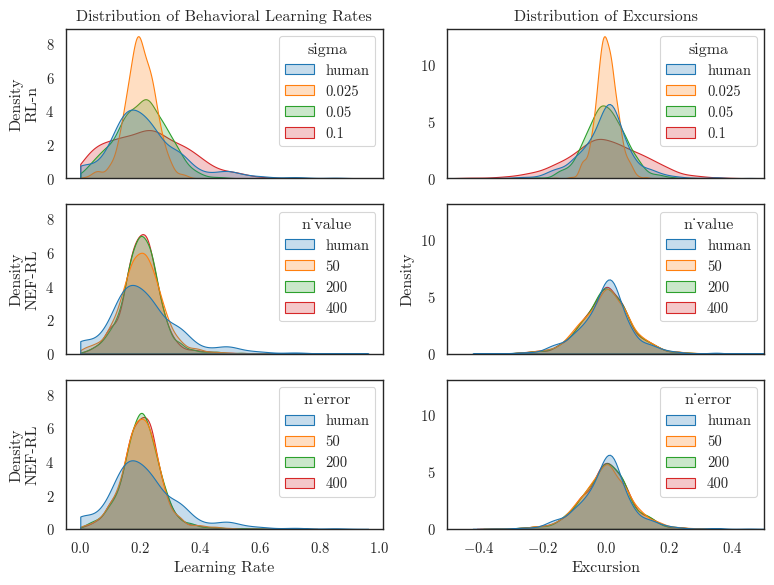

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 6), sharex='col', sharey='col')
# plot learning rates on left
sns.kdeplot(combined.query("type!='NEF_RL'"), x='alpha', hue='sigma', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type!='RL_n'"), x='alpha', hue='n_value', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type!='RL_n'"), x='alpha', hue='n_error', ax=axes[2][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
# plot excursions on right
sns.kdeplot(combined.query("type!='NEF_RL'"), x='excursion', hue='sigma', ax=axes[0][1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type!='RL_n'"), x='excursion', hue='n_value', ax=axes[1][1], palette=palette[:4], fill=True, common_norm=False)
sns.kdeplot(combined.query("type!='RL_n'"), x='excursion', hue='n_error', ax=axes[2][1], palette=palette[:4], fill=True, common_norm=False)
axes[0][0].set(title='Distribution of Behavioral Learning Rates', ylabel="Density\nRL-n")
axes[0][1].set(title='Distribution of Excursions', xlabel="Excursion", ylabel=None, xlim=[-0.5,0.5])
axes[1][0].set(ylabel="Density\nNEF-RL")
axes[2][0].set(ylabel="Density\nNEF-RL", xlabel="Learning Rate")
axes[2][1].set(ylabel=None, xlabel='Excursion')
plt.tight_layout()
# fig.savefig("plots/alpha_excursions_vs_neurons_demo.jpg", dpi=600)

### Neurons in different NEF_RL populations vs alpha/excursion

In [2]:
def process_plot(human, NEFRL_data):
    human['n_neurons'] = 'human'
    human['n_error'] = 'human'
    combined = pd.concat([human, NEFRL_data], ignore_index=True)
    combined['alpha'] = None
    combined['excursion'] = None
    for i, row in combined.iterrows():
        mt = row['type']
        trial = row['trial']
        stage = row['stage']
        qid = row['qid']
        n_neurons = row['n_neurons']
        n_error = row['n_error']
        response = row['response']
        avg_response = combined.query("type==@mt & n_neurons==@n_neurons & n_error==@n_error & qid==@qid")['response'].mean()
        combined.at[i, 'excursion'] = response - avg_response
        if stage>1:
            stage_old = stage - 1
            response_old = combined.query("type==@mt & trial==@trial & n_neurons==@n_neurons & n_error==@n_error & stage==@stage_old")['response'].to_numpy()[0]
            delta = response_old - response
            color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
            prediction_error = color - response_old
            alpha = np.abs(delta / prediction_error)
            combined.at[i, 'alpha'] = alpha
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharex='col', sharey='col')
    # plot learning rates on left
    sns.kdeplot(combined, x='alpha', hue='n_neurons', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
    sns.kdeplot(combined, x='alpha', hue='n_error', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
    # plot excursions on right
    sns.kdeplot(combined, x='excursion', hue='n_neurons', ax=axes[0][1], palette=palette[:4], fill=True, common_norm=False)
    sns.kdeplot(combined, x='excursion', hue='n_error', ax=axes[1][1], palette=palette[:4], fill=True, common_norm=False)
    axes[0][0].set(title='Distribution of Behavioral Learning Rates')
    axes[0][1].set(title='Distribution of Excursions', xlabel="Excursion", ylabel=None, xlim=[-0.5,0.5])
    axes[1][0].set(xlabel="Learning Rate")
    axes[1][1].set(ylabel=None, xlabel='Excursion')
    plt.tight_layout()
    plt.show()

In [ ]:
sid = 18

n_neurons = [50, 200]
# n_values = [50, 200, 400]
# n_values = [50, 200, 400]
# n = 200
v = 200
e = 200
dfs = []
for n in n_neurons:
# for v in n_values:
# for v in n_values:
    dfs.append(run_NEFRL(sid, n, v, e))
NEFRL_data = pd.concat(dfs, ignore_index=True)
human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")

/tmp/ipykernel_366262/2358177285.py:30: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.kdeplot(combined, x='alpha', hue='n_neurons', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_366262/2358177285.py:31: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='alpha', hue='n_value', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_366262/2358177285.py:32: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='alpha', hue='n_error', ax=axes[2][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_366262/2358177285.py:34: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.kdeplot(combined, x='excursion', hue='n_neurons', ax=axes[0][1], pale

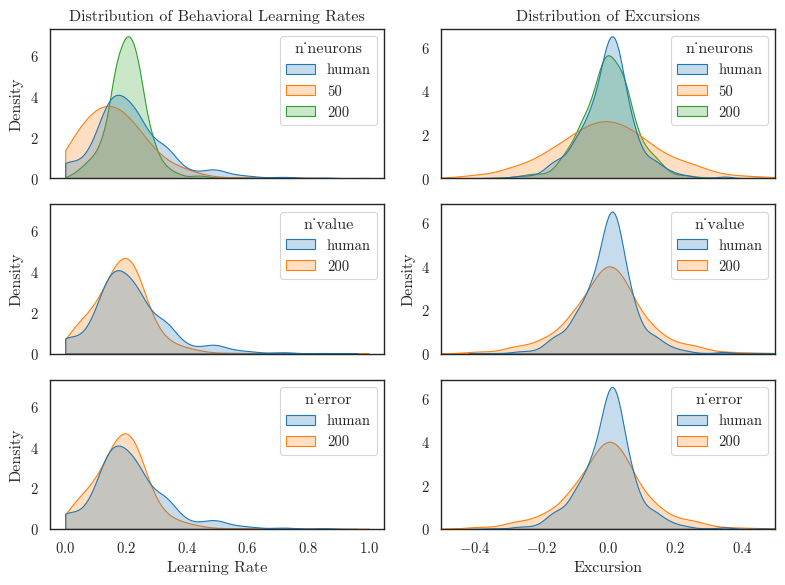

In [10]:
process_plot(human, NEFRL_data)

In [4]:
sid = 18

# n_neurons = [50, 200]
n_errors = [50, 200]
n = 200
# e = 200
dfs = []
# for n in n_neurons:
for e in n_errors:
    dfs.append(run_NEFRL(sid, n, e))
NEFRL_data = pd.concat(dfs, ignore_index=True)
human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")

n_neurons 200, n_error 50, sid 18, trial 1
n_neurons 200, n_error 50, sid 18, trial 2
n_neurons 200, n_error 50, sid 18, trial 3
n_neurons 200, n_error 50, sid 18, trial 4
n_neurons 200, n_error 50, sid 18, trial 5
n_neurons 200, n_error 50, sid 18, trial 6
n_neurons 200, n_error 50, sid 18, trial 7
n_neurons 200, n_error 50, sid 18, trial 8
n_neurons 200, n_error 50, sid 18, trial 9
n_neurons 200, n_error 50, sid 18, trial 10
n_neurons 200, n_error 50, sid 18, trial 11
n_neurons 200, n_error 50, sid 18, trial 12
n_neurons 200, n_error 50, sid 18, trial 13
n_neurons 200, n_error 50, sid 18, trial 14
n_neurons 200, n_error 50, sid 18, trial 15
n_neurons 200, n_error 50, sid 18, trial 16
n_neurons 200, n_error 50, sid 18, trial 17
n_neurons 200, n_error 50, sid 18, trial 18
n_neurons 200, n_error 50, sid 18, trial 19
n_neurons 200, n_error 50, sid 18, trial 20
n_neurons 200, n_error 50, sid 18, trial 21
n_neurons 200, n_error 50, sid 18, trial 22
n_neurons 200, n_error 50, sid 18, trial 

/tmp/ipykernel_370140/1176275660.py:28: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='alpha', hue='n_neurons', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:29: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.kdeplot(combined, x='alpha', hue='n_error', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:31: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='excursion', hue='n_neurons', ax=axes[0][1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:32: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.kdeplot(combined, x='excursion', hue='n_error', ax=axes[1][1], palette=palet

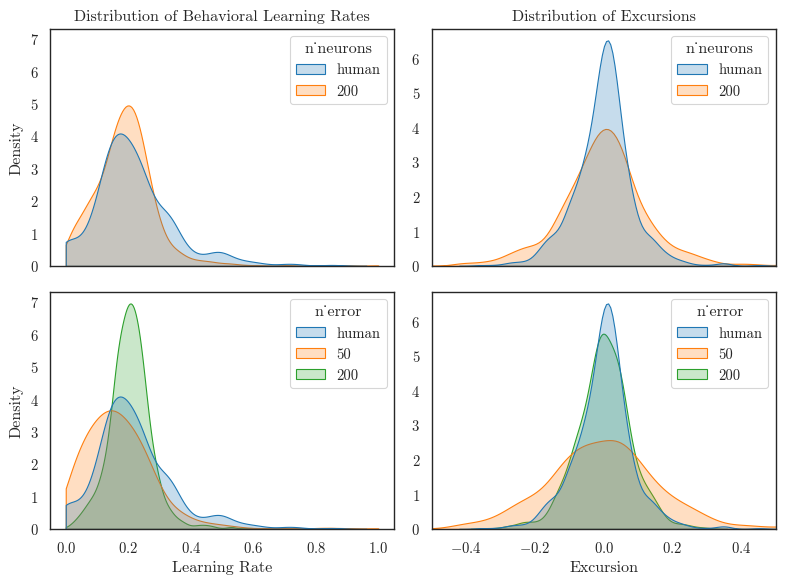

In [5]:
process_plot(human, NEFRL_data)

In [6]:
sid = 18

n_neurons = [30, 50, 200]
# n_errors = [50, 200]
# n = 200
e = 250
dfs = []
for n in n_neurons:
# for e in n_errors:
    dfs.append(run_NEFRL(sid, n, e))
NEFRL_data = pd.concat(dfs, ignore_index=True)
human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")

n_neurons 30, n_error 250, sid 18, trial 1
n_neurons 30, n_error 250, sid 18, trial 2
n_neurons 30, n_error 250, sid 18, trial 3
n_neurons 30, n_error 250, sid 18, trial 4
n_neurons 30, n_error 250, sid 18, trial 5
n_neurons 30, n_error 250, sid 18, trial 6
n_neurons 30, n_error 250, sid 18, trial 7
n_neurons 30, n_error 250, sid 18, trial 8
n_neurons 30, n_error 250, sid 18, trial 9
n_neurons 30, n_error 250, sid 18, trial 10
n_neurons 30, n_error 250, sid 18, trial 11
n_neurons 30, n_error 250, sid 18, trial 12
n_neurons 30, n_error 250, sid 18, trial 13
n_neurons 30, n_error 250, sid 18, trial 14
n_neurons 30, n_error 250, sid 18, trial 15
n_neurons 30, n_error 250, sid 18, trial 16
n_neurons 30, n_error 250, sid 18, trial 17
n_neurons 30, n_error 250, sid 18, trial 18
n_neurons 30, n_error 250, sid 18, trial 19
n_neurons 30, n_error 250, sid 18, trial 20
n_neurons 30, n_error 250, sid 18, trial 21
n_neurons 30, n_error 250, sid 18, trial 22
n_neurons 30, n_error 250, sid 18, trial 

/tmp/ipykernel_370140/1176275660.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='alpha', hue='n_error', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:32: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='excursion', hue='n_error', ax=axes[1][1], palette=palette[:4], fill=True, common_norm=False)


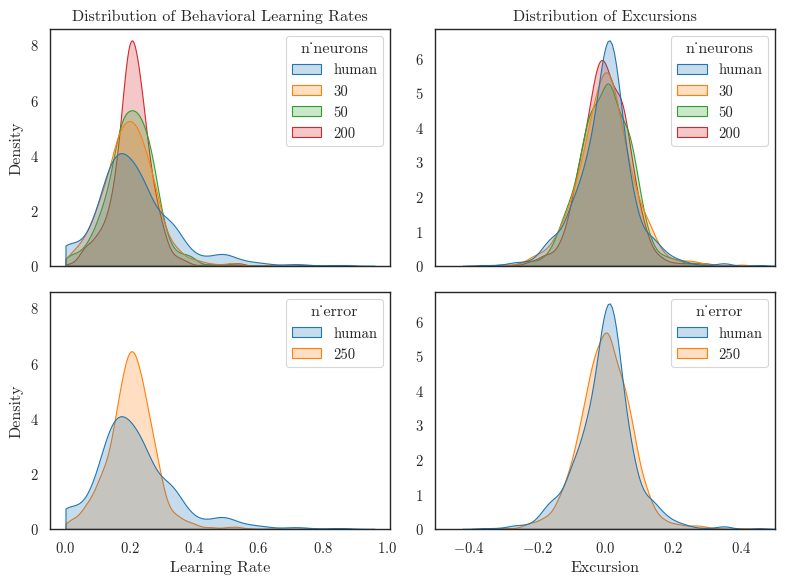

In [7]:
process_plot(human, NEFRL_data)

In [8]:
sid = 18

n_neurons = [10, 30, 100]
n_errors = [50, 300]
# n = 200
# e = 250
dfs = []
for n in n_neurons:
    for e in n_errors:
        dfs.append(run_NEFRL(sid, n, e))
NEFRL_data = pd.concat(dfs, ignore_index=True)
human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")

n_neurons 10, n_error 50, sid 18, trial 1
n_neurons 10, n_error 50, sid 18, trial 2
n_neurons 10, n_error 50, sid 18, trial 3
n_neurons 10, n_error 50, sid 18, trial 4
n_neurons 10, n_error 50, sid 18, trial 5
n_neurons 10, n_error 50, sid 18, trial 6
n_neurons 10, n_error 50, sid 18, trial 7
n_neurons 10, n_error 50, sid 18, trial 8
n_neurons 10, n_error 50, sid 18, trial 9
n_neurons 10, n_error 50, sid 18, trial 10
n_neurons 10, n_error 50, sid 18, trial 11
n_neurons 10, n_error 50, sid 18, trial 12
n_neurons 10, n_error 50, sid 18, trial 13
n_neurons 10, n_error 50, sid 18, trial 14
n_neurons 10, n_error 50, sid 18, trial 15
n_neurons 10, n_error 50, sid 18, trial 16
n_neurons 10, n_error 50, sid 18, trial 17
n_neurons 10, n_error 50, sid 18, trial 18
n_neurons 10, n_error 50, sid 18, trial 19
n_neurons 10, n_error 50, sid 18, trial 20
n_neurons 10, n_error 50, sid 18, trial 21
n_neurons 10, n_error 50, sid 18, trial 22
n_neurons 10, n_error 50, sid 18, trial 23
n_neurons 10, n_erro

/tmp/ipykernel_370140/1176275660.py:29: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.kdeplot(combined, x='alpha', hue='n_error', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:32: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.kdeplot(combined, x='excursion', hue='n_error', ax=axes[1][1], palette=palette[:4], fill=True, common_norm=False)


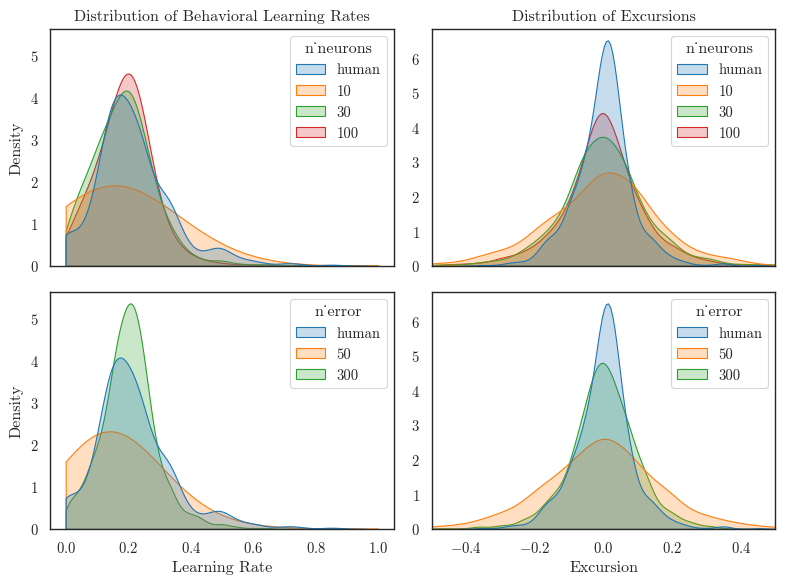

In [9]:
process_plot(human, NEFRL_data)

In [14]:
sid = 18
n = 15
e = 500
dfs = []
dfs.append(run_NEFRL(sid, n, e))
NEFRL_data = pd.concat(dfs, ignore_index=True)
human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")

n_neurons 15, n_error 500, sid 18, trial 1
n_neurons 15, n_error 500, sid 18, trial 2
n_neurons 15, n_error 500, sid 18, trial 3
n_neurons 15, n_error 500, sid 18, trial 4
n_neurons 15, n_error 500, sid 18, trial 5
n_neurons 15, n_error 500, sid 18, trial 6
n_neurons 15, n_error 500, sid 18, trial 7
n_neurons 15, n_error 500, sid 18, trial 8
n_neurons 15, n_error 500, sid 18, trial 9
n_neurons 15, n_error 500, sid 18, trial 10
n_neurons 15, n_error 500, sid 18, trial 11
n_neurons 15, n_error 500, sid 18, trial 12
n_neurons 15, n_error 500, sid 18, trial 13
n_neurons 15, n_error 500, sid 18, trial 14
n_neurons 15, n_error 500, sid 18, trial 15
n_neurons 15, n_error 500, sid 18, trial 16
n_neurons 15, n_error 500, sid 18, trial 17
n_neurons 15, n_error 500, sid 18, trial 18
n_neurons 15, n_error 500, sid 18, trial 19
n_neurons 15, n_error 500, sid 18, trial 20
n_neurons 15, n_error 500, sid 18, trial 21
n_neurons 15, n_error 500, sid 18, trial 22
n_neurons 15, n_error 500, sid 18, trial 

/tmp/ipykernel_370140/1176275660.py:28: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='alpha', hue='n_neurons', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='alpha', hue='n_error', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:31: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='excursion', hue='n_neurons', ax=axes[0][1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:32: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='excursion', hue='n_error', ax=axes[1][1], palette=palet

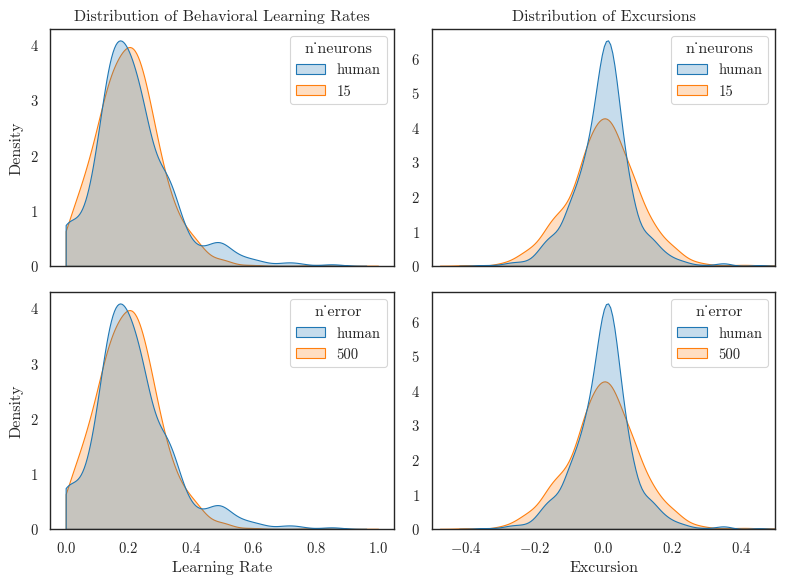

In [15]:
process_plot(human, NEFRL_data)

In [16]:
sid = 18
n = 15
e = 1500
dfs = []
dfs.append(run_NEFRL(sid, n, e))
NEFRL_data = pd.concat(dfs, ignore_index=True)
human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")

n_neurons 15, n_error 1500, sid 18, trial 1
n_neurons 15, n_error 1500, sid 18, trial 2
n_neurons 15, n_error 1500, sid 18, trial 3
n_neurons 15, n_error 1500, sid 18, trial 4
n_neurons 15, n_error 1500, sid 18, trial 5
n_neurons 15, n_error 1500, sid 18, trial 6
n_neurons 15, n_error 1500, sid 18, trial 7
n_neurons 15, n_error 1500, sid 18, trial 8
n_neurons 15, n_error 1500, sid 18, trial 9
n_neurons 15, n_error 1500, sid 18, trial 10
n_neurons 15, n_error 1500, sid 18, trial 11
n_neurons 15, n_error 1500, sid 18, trial 12
n_neurons 15, n_error 1500, sid 18, trial 13
n_neurons 15, n_error 1500, sid 18, trial 14
n_neurons 15, n_error 1500, sid 18, trial 15
n_neurons 15, n_error 1500, sid 18, trial 16
n_neurons 15, n_error 1500, sid 18, trial 17
n_neurons 15, n_error 1500, sid 18, trial 18
n_neurons 15, n_error 1500, sid 18, trial 19
n_neurons 15, n_error 1500, sid 18, trial 20
n_neurons 15, n_error 1500, sid 18, trial 21
n_neurons 15, n_error 1500, sid 18, trial 22
n_neurons 15, n_err

/tmp/ipykernel_370140/1176275660.py:28: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='alpha', hue='n_neurons', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='alpha', hue='n_error', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:31: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='excursion', hue='n_neurons', ax=axes[0][1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:32: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='excursion', hue='n_error', ax=axes[1][1], palette=palet

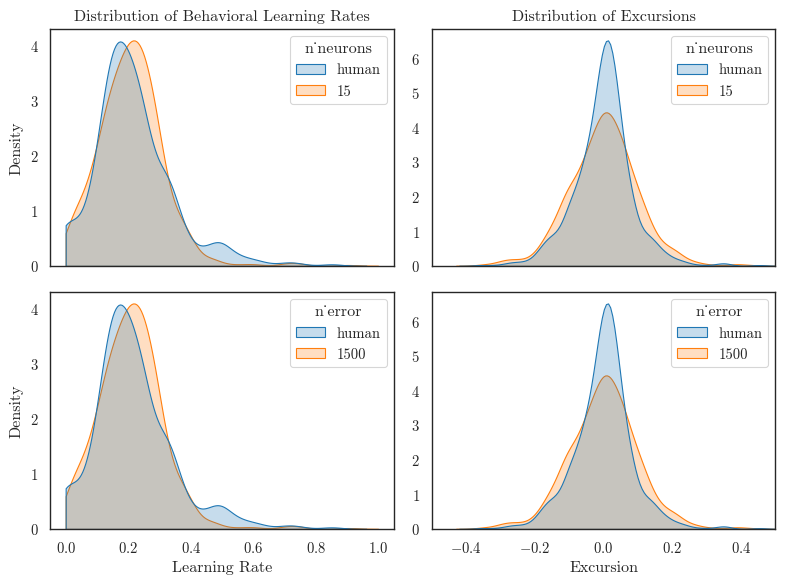

In [18]:
process_plot(human, NEFRL_data)

n_neurons 50, n_error 300, sid 18, trial 1
n_neurons 50, n_error 300, sid 18, trial 2
n_neurons 50, n_error 300, sid 18, trial 3
n_neurons 50, n_error 300, sid 18, trial 4
n_neurons 50, n_error 300, sid 18, trial 5
n_neurons 50, n_error 300, sid 18, trial 6
n_neurons 50, n_error 300, sid 18, trial 7
n_neurons 50, n_error 300, sid 18, trial 8
n_neurons 50, n_error 300, sid 18, trial 9
n_neurons 50, n_error 300, sid 18, trial 10
n_neurons 50, n_error 300, sid 18, trial 11
n_neurons 50, n_error 300, sid 18, trial 12
n_neurons 50, n_error 300, sid 18, trial 13
n_neurons 50, n_error 300, sid 18, trial 14
n_neurons 50, n_error 300, sid 18, trial 15
n_neurons 50, n_error 300, sid 18, trial 16
n_neurons 50, n_error 300, sid 18, trial 17
n_neurons 50, n_error 300, sid 18, trial 18
n_neurons 50, n_error 300, sid 18, trial 19
n_neurons 50, n_error 300, sid 18, trial 20
n_neurons 50, n_error 300, sid 18, trial 21
n_neurons 50, n_error 300, sid 18, trial 22
n_neurons 50, n_error 300, sid 18, trial 

/tmp/ipykernel_370140/1176275660.py:28: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='alpha', hue='n_neurons', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:29: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='alpha', hue='n_error', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:31: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='excursion', hue='n_neurons', ax=axes[0][1], palette=palette[:4], fill=True, common_norm=False)
/tmp/ipykernel_370140/1176275660.py:32: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.kdeplot(combined, x='excursion', hue='n_error', ax=axes[1][1], palette=palet

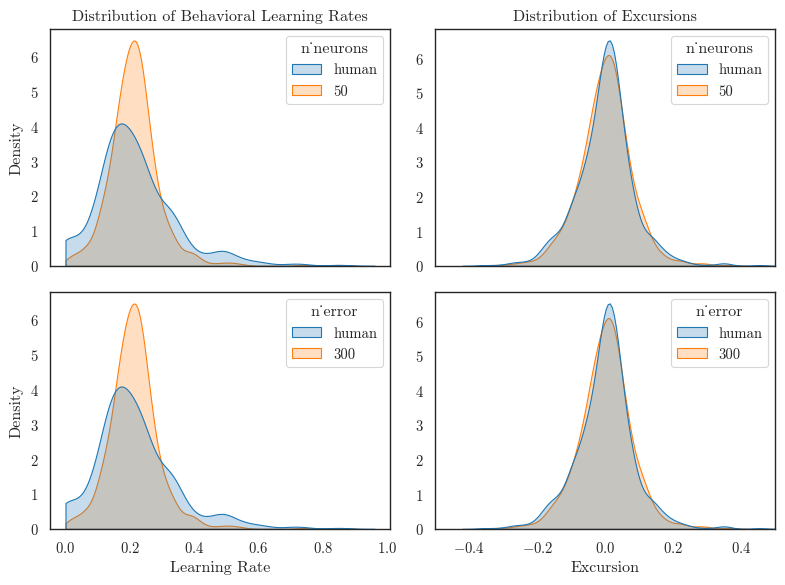

In [19]:
sid = 18
n = 50
e = 300
dfs = []
dfs.append(run_NEFRL(sid, n, e))
NEFRL_data = pd.concat(dfs, ignore_index=True)
human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
process_plot(human, NEFRL_data)